# Régimes de temps toutes saison

In [1]:
%matplotlib inline

import calendar
from calendar import isleap
import datetime
import os

import numpy as np
from scipy.stats import gaussian_kde
from scipy.signal import savgol_filter

import IPython.display as IPdisplay, matplotlib.font_manager as fm
from PIL import Image
import glob

import xarray as xr
from netCDF4 import Dataset

import pandas as pd
from pandas import Series
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import Colormap as cm
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.path as mpath

from cartopy import config
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from eofs.standard import Eof

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
dir_data='./data/'
dir_res='./result/'
dir_figs='./figs/'
dir_anim='./anim/'

if not os.path.exists(dir_figs):
    os.makedirs(dir_figs)
if not os.path.exists(dir_anim):
    os.makedirs(dir_anim)
if not os.path.exists(dir_res):
    os.makedirs(dir_res)

In [13]:
infile = dir_data+'era5_z500_natl_daily_1950-2020_1deg5.nc'
data0    = xr.open_dataset(infile)

In [14]:
startday  = '1980-01-01T18'
endday  = '2020-12-31T18'

startyear = startday[0:4]

latS=20
latN=80
lonW=-80
lonE=30

# Date index from startday to endday
dates = pd.date_range(startday, endday, freq='D')

#Exclusion du 29 février
jours=np.any([dates.day!=29,dates.month!=2],axis=0)
dates2=dates[jours]

In [15]:
data = data0.assign_coords(lon=(((data0.lon + 180) % 360) - 180)).sortby('lon')
data_season = data.sel(lat=slice(latS,latN)).sel(lon=slice(lonW,lonE)).sel(time=slice(startday,endday)).sel(time=dates2)

lat  = data_season.lat.values
lon  = data_season.lon.values
time  = data_season.time.values


In [16]:
bounds = [lonW, lonE, latS, latN]

In [7]:
moyenne_jour=data_season.groupby('time.dayofyear').mean('time')

In [8]:
#Calcul d'anomalie par retrait de la moyenne lissée avec un polynoôme
moyenne=np.array(moyenne_jour.to_array())[0]
moyenne_lissee=np.copy(moyenne)
(d,m,n)=moyenne.shape
liste_jours=[nb_jour for nb_jour in range(d)]
deg=10
for i in range(m):
    for j in range(n):
        #calcul des coefficients de l'ajustement polynomial de degré deg
        coeff_moyenne=np.polyfit(liste_jours,moyenne[:,i,j],deg)
        #calcul de la moyenne lissée
        moyenne_lissee[:,i,j]=np.polyval(coeff_moyenne,liste_jours)

In [9]:
anomalies = data_season.groupby('time.dayofyear')-moyenne_jour
for (i,t) in zip(range(len(anomalies.time)),anomalies.time):
    anomalies["z"][i]=data_season["z"][i]-moyenne_lissee[t.dt.dayofyear.values-1]

In [10]:
#On se débarasse des nan en excluant les jours sur les bords du domaine (les 45 premiers et les 45 derniers)

delta = datetime.timedelta(days = 15)
startday2 = dates2[0] + delta
endday2 = dates2[-1]-delta

#dates3 servira pour le calcul des fréquences mensuelles
dates3 = pd.date_range(startday2, endday2, freq='D')
jours=np.any([dates3.day!=29,dates3.month!=2],axis=0)
dates3=dates3[jours]

In [11]:
anomalies=anomalies.sel(time=slice(startday2,endday2))

In [12]:
#Calcul de l'écart-type glissant sur une fenêtre de 30jours

data_normalise=data_season.rolling(time=30,center=True).std().sel(time=slice(startday2,endday2))

#Calcul de la moyenne spatiale

coeffs=[]

for nombre in data_normalise["z"]:

    coslat = np.cos(np.deg2rad(lat))
    wgts = np.reshape(coslat,(np.shape(coslat)[0],1))
    wgts2d=np.tile(wgts,(1,np.shape(nombre)[1]))
    coeffs.append(np.sum(nombre*wgts2d)/np.sum(wgts2d))


In [13]:
#Création d'une liste de coefficients de pondérations : un par pas de temps

coeffs2=[]
for i in range(len(coeffs)):
    coeffs2.append(coeffs[i].values.tolist())

In [14]:
anomalies_non_filtre = anomalies.copy(deep=True)

for i in range(len(anomalies.time)):
    anomalies_non_filtre["z"][i]=anomalies_non_filtre["z"][i]/coeffs2[i]


In [15]:
coeffs3=savgol_filter(coeffs2, 101, 2)

In [16]:
#Normalisation : on divise les anomalies par les coeffs.
for i in range(len(anomalies.time)):
    anomalies["z"][i]=anomalies["z"][i]/coeffs3[i]

In [17]:
infile1 = dir_res+"z500"
data_season.to_netcdf(infile1)

infile2=dir_res+"anoz500"
anomalies.to_netcdf(infile2)

In [18]:
filename = infile1
ncin = Dataset(filename, 'r')
lons = ncin.variables['lon'][:]
lats = ncin.variables['lat'][:]
z500 = ncin.variables['z'][:]
ncin.close()

filename = infile2
ncin = Dataset(filename, 'r')
lons = ncin.variables['lon'][:]
lats = ncin.variables['lat'][:]
Anoz500 = ncin.variables['z'][:]
ncin.close()

In [19]:
coslat = np.sqrt(np.cos(np.deg2rad(lat)))
wgts = np.reshape(coslat,(np.shape(coslat)[0],1))
solver = Eof(Anoz500, weights=wgts, center=True)

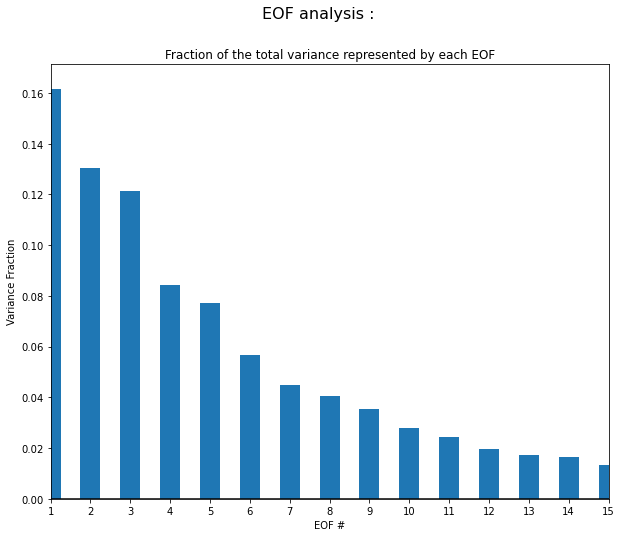

Variance expliquée par les 15 premières EOFs : 0.8713189187143628


In [20]:
varfrac = solver.varianceFraction()

fig = plt.figure(figsize=(10, 8))
fig.suptitle('EOF analysis : ', fontsize=16)

eof_num = range(1, 16)
plt.bar(eof_num, varfrac[0:15], width=0.5)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 15)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)
plt.show()
print("Variance expliquée par les 15 premières EOFs : " + str(sum(varfrac[0:15])))

In [21]:
n=20
eofs = solver.eofsAsCovariance(neofs=n)
pcs = solver.pcs(npcs=n, pcscaling=0)

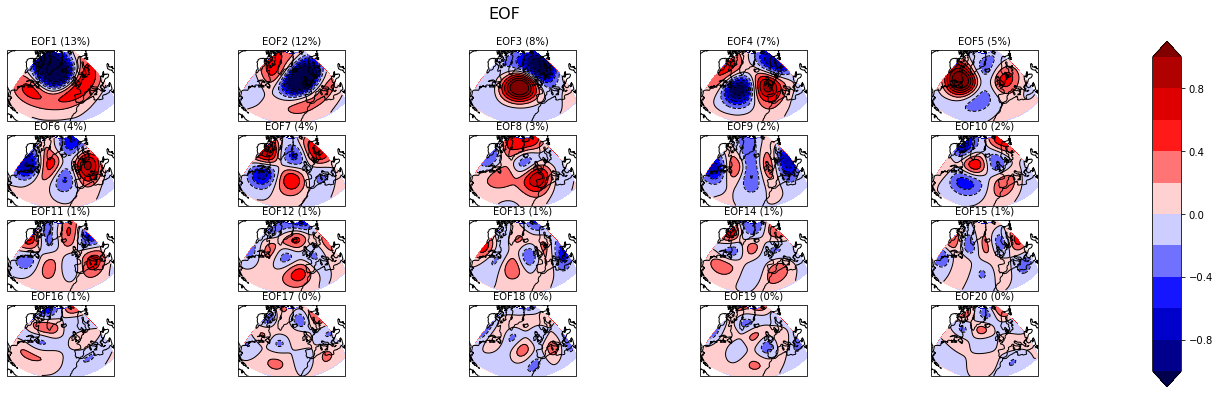

In [22]:
clevs = np.linspace(-1, 1, 11)
cmap = mpl.cm.seismic
norm = BoundaryNorm(clevs, cmap.N, extend='both')
fig=plt.figure(figsize=(20,6))
fig.suptitle('EOF', fontsize=16)

for ieof in np.arange(1,n+1):
    ax=fig.add_subplot(4,5,ieof,projection=ccrs.Orthographic(central_longitude=(lonW+lonE)/2, central_latitude=(latS+latN)/2))
    p = ax.pcolormesh(lons,\
                   lats,\
                   eofs[0],\
                   vmin=-1,\
                   vmax=1, \
                   transform=ccrs.PlateCarree(),\
                   cmap="seismic",norm=norm )
    ax.coastlines()
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    ax.set_title('EOF'+str(ieof)+' ('+str(int(varfrac[ieof]*100))+'%)', fontsize=10, loc='center')
    ax.contourf(lons, lats, eofs[ieof-1], clevs, transform=ccrs.PlateCarree(), cmap="seismic", extend='both')
    ax.contour(lons, lats, eofs[ieof-1], levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())

cb_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
cbar = plt.colorbar(p, cax=cb_ax,extend='both')

In [23]:
liste_col=[]
for i in range(n):
    liste_col.append(pcs[:,i])
pcs_inter=np.array(liste_col)
pcs=pcs_inter.transpose()
# Number of clusters
kmeans = KMeans(n_clusters=7,n_init=100)
# Fitting the input data
kmeans = kmeans.fit(pcs)
# Getting the cluster labels
cluster = kmeans.predict(pcs)
# Centroid values
centroids = kmeans.cluster_centers_

print(cluster)
print(cluster.shape)
print(centroids.shape)

[4 6 1 ... 1 1 1]
(14935,)
(7, 20)


In [24]:
nc=[list(cluster[:]).count(i) for i in range(7)]
freq=[int(x/cluster.shape[0]*100) for x in nc]

In [25]:
colors=[""]*len(cluster)
couleur=["blue","red","green","orange","yellow","brown","black"]
for i in range(len(cluster)):
    colors[i]=couleur[cluster[i]]



In [26]:
id_cluster=[np.any([cluster==i],axis=0) for i in range(8)]

#mean=[z500[x,:,:].mean(axis=0)/9.81 for x in id_cluster]
anom=[Anoz500[x,:,:].mean(axis=0)/9.81 for x in id_cluster]


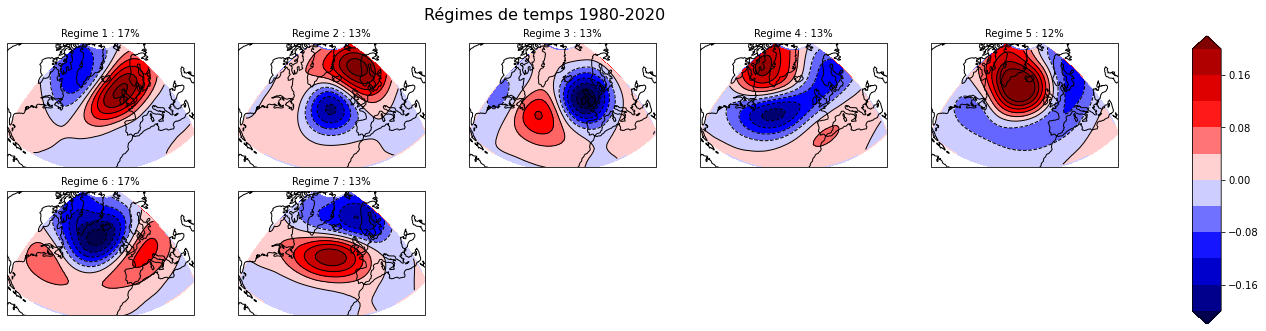

In [27]:
clevs = np.linspace(-0.2, 0.2, 11)
cmap = mpl.cm.seismic
norm = BoundaryNorm(clevs, cmap.N, extend='both')
fig=plt.figure(figsize=(20,5))
fig.suptitle('Régimes de temps ' + startyear+'-2020', fontsize=16)

for ianom in np.arange(1,8):
    ax=fig.add_subplot(2,5,ianom,projection=ccrs.Orthographic(central_longitude=(lonW+lonE)/2, central_latitude=(latS+latN)/2))
    p = ax.pcolormesh(lons,\
                   lats,\
                   anom[0],\
                   vmin=-0.2,\
                   vmax=0.2, \
                   transform=ccrs.PlateCarree(),\
                   cmap="seismic",norm=norm )
    ax.coastlines()
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    ax.set_title('Regime '+str(ianom)+' : '+str(freq[ianom-1])+'%', fontsize=10, loc='center', color=couleur[6])
    ax.contourf(lons, lats, anom[ianom-1], clevs, transform=ccrs.PlateCarree(), cmap="seismic", extend='both')
    ax.contour(lons, lats, anom[ianom-1], levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())

cb_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
cbar = plt.colorbar(p, cax=cb_ax,extend='both')

In [28]:
def nommer_régimes():
    Regimes=[]
    for i in range(7):
        Regimes.append(str(input("Identifiez le nom du régime n° "+str(i+1))))
    return Regimes

In [29]:
Regimes=nommer_régimes()

Identifiez le nom du régime n° 1EuBl
Identifiez le nom du régime n° 2ScBl
Identifiez le nom du régime n° 3AtlLo
Identifiez le nom du régime n° 4GlBl
Identifiez le nom du régime n° 5AtlRi
Identifiez le nom du régime n° 6Zo
Identifiez le nom du régime n° 7ScLo


In [30]:
Regimes.append("Pas de régimes")

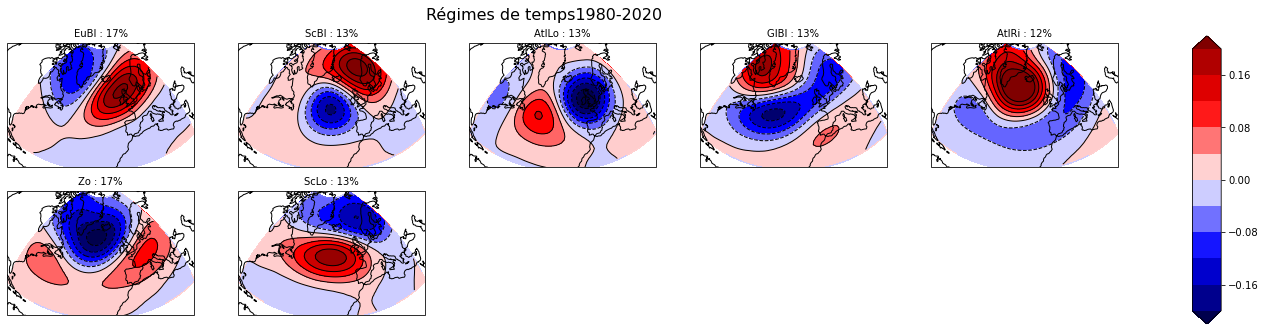

In [31]:
clevs = np.linspace(-0.2, 0.2, 11)
cmap = mpl.cm.seismic
norm = BoundaryNorm(clevs, cmap.N, extend='both')
fig=plt.figure(figsize=(20,5))
fig.suptitle('Régimes de temps' + startyear+'-2020', fontsize=16)

for ianom in np.arange(1,8):
    if ianom==8 :
        titre="Pas de régime"
    else:
        titre=str(Regimes[ianom-1])+" : " 
    
    ax=fig.add_subplot(2,5,ianom,projection=ccrs.Orthographic(central_longitude=(lonW+lonE)/2, central_latitude=(latS+latN)/2))
    p = ax.pcolormesh(lons,\
                   lats,\
                   anom[0],\
                   vmin=-0.2,\
                   vmax=0.2, \
                   transform=ccrs.PlateCarree(),\
                   cmap="seismic",norm=norm )
    ax.coastlines()
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    ax.set_title(titre+str(freq[ianom-1])+'%', fontsize=10, loc='center', color=couleur[6])
    ax.contourf(lons, lats, anom[ianom-1], clevs, transform=ccrs.PlateCarree(), cmap="seismic", extend='both')
    ax.contour(lons, lats, anom[ianom-1], levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())

cb_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
cbar = plt.colorbar(p, cax=cb_ax,extend='both')

# Declustering

In [32]:
def declustering(cluster):
    cluster2=cluster.copy()
    liste_sequences = []
    persistance_globale = []
    persistance_par_régime={'0':[],'1':[],'2':[],'3':[],'4':[],'5':[],'6':[],'7':[]}
    
    #Création d'une liste de séquences EX [1,1,2,3,3,3,2,2,1] devient [[1,1,1],[2],[3,3,3],[2,2],[1]]
    while len(cluster2)!= 0 :
        seq=[]
        i=0
        while i<len(cluster2) and cluster2[i]==cluster2[0]:
            seq.append(cluster2[i])
            i+=1
        liste_sequences.append(seq)
        persistance_globale.append(len(seq))
        persistance_par_régime[str(cluster2[0])].append(len(seq))
        del cluster2[0:i]
    
    new_cluster=[]
    #Les séquences inférieures à trois jours sont remplacées par des "7", (numéro du régime "poubelle")
    #Ensuite, on remet toutes ces séquences les unes à la suite des autres pour obtenir un nouvel array à 8 régimes (les 7 d'origines + la poubelle)
    for sequence in liste_sequences:
        if len(sequence)<3 :
            sequence=len(sequence)*[7]
        for element in sequence :
            new_cluster.append(element)
    
    return (np.array(new_cluster),persistance_globale,persistance_par_régime)
            

In [33]:
cluster=declustering(cluster.tolist())[0]

In [34]:
nc=[list(cluster[:]).count(i) for i in range(8)]
freq=[int(x/cluster.shape[0]*100) for x in nc]

In [35]:
id_cluster=[np.any([cluster==i],axis=0) for i in range(8)]
anom=[Anoz500[x,:,:].mean(axis=0)/9.81 for x in id_cluster]

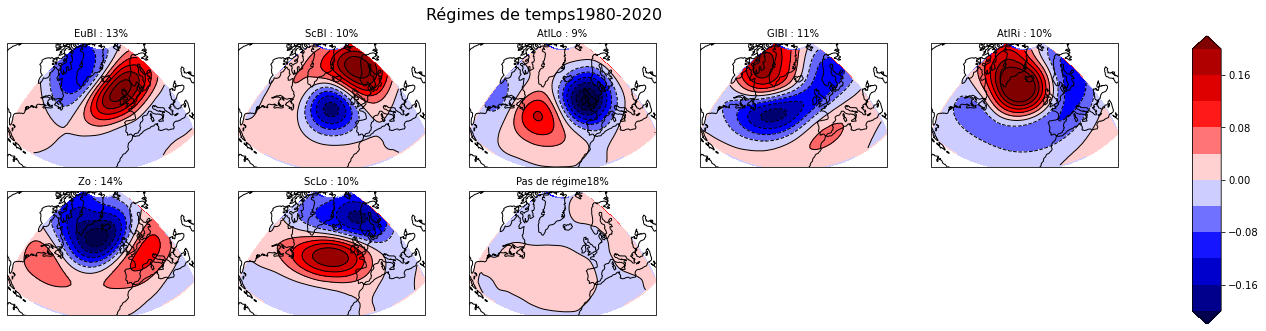

In [36]:
clevs = np.linspace(-0.2, 0.2, 11)
cmap = mpl.cm.seismic
norm = BoundaryNorm(clevs, cmap.N, extend='both')
fig=plt.figure(figsize=(20,5))
fig.suptitle('Régimes de temps' + startyear+'-2020', fontsize=16)

for ianom in np.arange(1,9):
    if ianom==8 :
        titre="Pas de régime"
    else:
        titre=str(Regimes[ianom-1])+" : " 
    
    ax=fig.add_subplot(2,5,ianom,projection=ccrs.Orthographic(central_longitude=(lonW+lonE)/2, central_latitude=(latS+latN)/2))
    p = ax.pcolormesh(lons,\
                   lats,\
                   anom[0],\
                   vmin=-0.2,\
                   vmax=0.2, \
                   transform=ccrs.PlateCarree(),\
                   cmap="seismic",norm=norm )
    ax.coastlines()
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    ax.set_title(titre+str(freq[ianom-1])+'%', fontsize=10, loc='center', color=couleur[6])
    ax.contourf(lons, lats, anom[ianom-1], clevs, transform=ccrs.PlateCarree(), cmap="seismic", extend='both')
    ax.contour(lons, lats, anom[ianom-1], levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())

cb_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
cbar = plt.colorbar(p, cax=cb_ax,extend='both')

In [92]:
#enregistre data
with open(dir_res+'cluster.txt', 'w') as clstr :
    for i in cluster :
        clstr.write(str(i))
with open(dir_res+'cluster.txt', 'a') as clstr :
    clstr.write('\n'+str(Regimes[:]))
            

In [3]:
#lire data
with open(dir_res+'cluster.txt', 'r') as clstr :
    cluster = np.array([int(i) for i in clstr.readline().replace('\n','')])
    Regimes = clstr.readline().replace("'",'').replace('[','').replace(']','').split(',')

### Temps Sensible associé aux régimes 

In [4]:
d1='1980-01-01T09'
d2='2019-12-31T18'

dates6 = pd.date_range(d1, d2, freq='D')
jours6 = np.any([dates6.day!=29,dates6.month!=2],axis=0)
dates6 = dates6[jours6]

# data_wind10 = xr.open_dataset(dir_data+'wind10_eur_19790101_20191231.nc').sel(time=dates6)
# data_u10 = xr.open_dataset(dir_data+'u10_eur_19790101_20191231.nc').sel(time=dates6)
# data_v10 = xr.open_dataset(dir_data+'v10_eur_19790101_20191231.nc').sel(time=dates6)

# data_t = xr.open_dataset(dir_data+'t2m_eur_19790101_20191231.nc').sel(time=dates6)

data_tp = xr.open_dataset(dir_data+'tp_eur_19790101_20191231.nc').sel(time=dates6)

lat_t  = data_tp.latitude.values
lon_t  = data_tp.longitude.values
time_t  = data_tp.time.values

In [5]:
# data_wind10_anom = data_wind10.groupby('time.dayofyear') - data_wind10.groupby('time.dayofyear').mean('time')
# wind10_anom = data_wind10_anom['ws'][15:]
# data_u10 = data_u10['u10'][15:]
# data_v10 = data_v10['v10'][15:]

In [6]:
# data_t_anom = data_t.groupby('time.dayofyear') - data_t.groupby('time.dayofyear').mean('time')
# t2m_anom=data_t_anom['t2m'][15:]

In [7]:
data_tp_anom = data_tp.groupby('time.dayofyear') - data_tp.groupby('time.dayofyear').mean('time')
tp_anom=data_tp_anom['tp'][15:]*1000

In [28]:
data_tp_anom = data_tp.groupby('time.season') - data_tp.groupby('time.season').mean('time')
tp_anom=data_tp_anom['tp'][15:]*1000

In [23]:
index_y=np.all([dates2>=d1, dates2<=d2], axis=0)[15:-15]
cluster_t=cluster[index_y]

In [24]:
id_cluster1_t=np.any([cluster_t==0],axis=0)
id_cluster2_t=np.any([cluster_t==1],axis=0)
id_cluster3_t=np.any([cluster_t==2],axis=0)
id_cluster4_t=np.any([cluster_t==3],axis=0)
id_cluster5_t=np.any([cluster_t==4],axis=0)
id_cluster6_t=np.any([cluster_t==5],axis=0)
id_cluster7_t=np.any([cluster_t==6],axis=0)

# mean_c1_anom_wind10 = wind10_anom[id_cluster1_t,:,:].mean(axis=0)
# mean_c2_anom_wind10 = wind10_anom[id_cluster2_t,:,:].mean(axis=0)
# mean_c3_anom_wind10 = wind10_anom[id_cluster3_t,:,:].mean(axis=0)
# mean_c4_anom_wind10 = wind10_anom[id_cluster4_t,:,:].mean(axis=0)
# mean_c5_anom_wind10 = wind10_anom[id_cluster5_t,:,:].mean(axis=0)
# mean_c6_anom_wind10 = wind10_anom[id_cluster6_t,:,:].mean(axis=0)
# mean_c7_anom_wind10 = wind10_anom[id_cluster7_t,:,:].mean(axis=0)

# mean_c1_u10 = np.array(data_u10[id_cluster1_t,:,:].mean(axis=0))
# mean_c2_u10 = np.array(data_u10[id_cluster2_t,:,:].mean(axis=0))
# mean_c3_u10 = np.array(data_u10[id_cluster3_t,:,:].mean(axis=0))
# mean_c4_u10 = np.array(data_u10[id_cluster4_t,:,:].mean(axis=0))
# mean_c5_u10 = np.array(data_u10[id_cluster5_t,:,:].mean(axis=0))
# mean_c6_u10 = np.array(data_u10[id_cluster6_t,:,:].mean(axis=0))
# mean_c7_u10 = np.array(data_u10[id_cluster7_t,:,:].mean(axis=0))

# mean_c1_v10 = np.array(data_v10[id_cluster1_t,:,:].mean(axis=0))
# mean_c2_v10 = np.array(data_v10[id_cluster2_t,:,:].mean(axis=0))
# mean_c3_v10 = np.array(data_v10[id_cluster3_t,:,:].mean(axis=0))
# mean_c4_v10 = np.array(data_v10[id_cluster4_t,:,:].mean(axis=0))
# mean_c5_v10 = np.array(data_v10[id_cluster5_t,:,:].mean(axis=0))
# mean_c6_v10 = np.array(data_v10[id_cluster6_t,:,:].mean(axis=0))
# mean_c7_v10 = np.array(data_v10[id_cluster7_t,:,:].mean(axis=0))

# mean_c1_anom_t = t2m_anom[id_cluster1_t,:,:].mean(axis=0)
# mean_c2_anom_t = t2m_anom[id_cluster2_t,:,:].mean(axis=0)
# mean_c3_anom_t = t2m_anom[id_cluster3_t,:,:].mean(axis=0)
# mean_c4_anom_t = t2m_anom[id_cluster4_t,:,:].mean(axis=0)
# mean_c5_anom_t = t2m_anom[id_cluster5_t,:,:].mean(axis=0)
# mean_c6_anom_t = t2m_anom[id_cluster6_t,:,:].mean(axis=0)
# mean_c7_anom_t = t2m_anom[id_cluster7_t,:,:].mean(axis=0)

mean_c1_anom_tp = tp_anom[id_cluster1_t,:,:].mean(axis=0)
mean_c2_anom_tp = tp_anom[id_cluster2_t,:,:].mean(axis=0)
mean_c3_anom_tp = tp_anom[id_cluster3_t,:,:].mean(axis=0)
mean_c4_anom_tp = tp_anom[id_cluster4_t,:,:].mean(axis=0)
mean_c5_anom_tp = tp_anom[id_cluster5_t,:,:].mean(axis=0)
mean_c6_anom_tp = tp_anom[id_cluster6_t,:,:].mean(axis=0)
mean_c7_anom_tp = tp_anom[id_cluster7_t,:,:].mean(axis=0)

In [25]:
cmap1='jet'
cmap2='RdBu_r'
def make_boundary_path(lon,lat):
    lons,lats=np.meshgrid(lon,lat)
    boundary_path = np.array([lons[-1,:],lats[-1,:]])
    boundary_path = np.append(boundary_path,np.array([lons[::-1,-1],lats[::-1,-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[1,::-1],lats[1,::-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[:,1],lats[:,1]]),axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path

NameError: name 'mean_c1_u10' is not defined

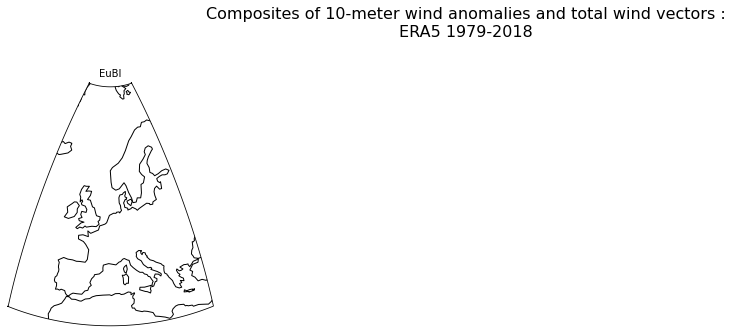

In [26]:
projection2=ccrs.NearsidePerspective(central_longitude=5.0, central_latitude=55.0)
bounds = [(-20, 30, 30, 80)]

levs_wind10_anom = np.linspace(-2, 2, 21)

fig = plt.figure(figsize=(17, 10))
fig.suptitle('Composites of 10-meter wind anomalies and total wind vectors :\nERA5 1979-2018', fontsize=16)

ax = fig.add_subplot(2, 4, 1, projection=projection2)
plt.title(Regimes[0], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
ax.quiver(lon_t, lat_t, mean_c1_u10, mean_c1_v10, transform=ccrs.PlateCarree(), regrid_shape = 20, zorder = 2)
cf = ax.contourf(lon_t, lat_t, mean_c1_anom_wind10, levels=levs_wind10_anom, 
                 cmap=cmap2, alpha = 0.7, extend='both', transform=ccrs.PlateCarree(), zorder = 1)
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly ($m.s^{-1}$)', fontsize=12)

ax = fig.add_subplot(2, 4, 2, projection=projection2)
plt.title(Regimes[1], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
ax.quiver(lon_t, lat_t, mean_c2_u10, mean_c2_v10, transform=ccrs.PlateCarree(), regrid_shape = 20, zorder = 2)
cf = ax.contourf(lon_t, lat_t, mean_c2_anom_wind10, levels=levs_wind10_anom, 
                 cmap=cmap2, alpha = 0.7, extend='both', transform=ccrs.PlateCarree(), zorder = 1)
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly ($m.s^{-1}$)', fontsize=12)

ax = fig.add_subplot(2, 4, 3, projection=projection2)
plt.title(Regimes[2], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
ax.quiver(lon_t, lat_t, mean_c3_u10, mean_c3_v10, transform=ccrs.PlateCarree(), regrid_shape = 20, zorder = 2)
cf = ax.contourf(lon_t, lat_t, mean_c3_anom_wind10, levels=levs_wind10_anom, 
                 cmap=cmap2, alpha = 0.7, extend='both', transform=ccrs.PlateCarree(), zorder = 1)
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly ($m.s^{-1}$)', fontsize=12)

ax = fig.add_subplot(2, 4, 4, projection=projection2)
plt.title(Regimes[3], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
ax.quiver(lon_t, lat_t, mean_c4_u10, mean_c4_v10, transform=ccrs.PlateCarree(), regrid_shape = 20, zorder = 2)
cf = ax.contourf(lon_t, lat_t, mean_c4_anom_wind10, levels=levs_wind10_anom, 
                 cmap=cmap2, alpha = 0.7, extend='both', transform=ccrs.PlateCarree(), zorder = 1)
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly ($m.s^{-1}$)', fontsize=12)

ax = fig.add_subplot(2, 4, 5, projection=projection2)
plt.title(Regimes[4], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
ax.quiver(lon_t, lat_t, mean_c5_u10, mean_c5_v10, transform=ccrs.PlateCarree(), regrid_shape = 20, zorder = 2)
cf = ax.contourf(lon_t, lat_t, mean_c5_anom_wind10, levels=levs_wind10_anom, 
                 cmap=cmap2, alpha = 0.7, extend='both', transform=ccrs.PlateCarree(), zorder = 1)
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly ($m.s^{-1}$)', fontsize=12)

ax = fig.add_subplot(2, 4, 6, projection=projection2)
plt.title(Regimes[5], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
ax.quiver(lon_t, lat_t, mean_c6_u10, mean_c6_v10, transform=ccrs.PlateCarree(), regrid_shape = 20, zorder = 2)
cf = ax.contourf(lon_t, lat_t, mean_c6_anom_wind10, levels=levs_wind10_anom, 
                 cmap=cmap2, alpha = 0.7, extend='both', transform=ccrs.PlateCarree(), zorder = 1)
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly ($m.s^{-1}$)', fontsize=12)

ax = fig.add_subplot(2, 4, 7, projection=projection2)
plt.title(Regimes[6], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
ax.quiver(lon_t, lat_t, mean_c7_u10, mean_c7_v10, transform=ccrs.PlateCarree(), regrid_shape = 20, zorder = 2)
cf = ax.contourf(lon_t, lat_t, mean_c7_anom_wind10, levels=levs_wind10_anom, 
                 cmap=cmap2, alpha = 0.7, extend='both', transform=ccrs.PlateCarree(), zorder = 1)
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly ($m.s^{-1}$)', fontsize=12)

plt.show()

fig.savefig(dir_figs+'z500_eu_v_composite'+'.jpeg', bbox_inches='tight')

In [ ]:
projection2=ccrs.NearsidePerspective(central_longitude=5.0, central_latitude=55.0)
bounds = [(-20, 30, 30, 80)]

levs_t_anom = np.linspace(-3, 3, 21)

fig = plt.figure(figsize=(15, 10))
fig.suptitle('Composites of 2-meter temperature anomalies : ERA5 1979-2018', fontsize=16)

ax = fig.add_subplot(2, 4, 1, projection=projection2)
plt.title(Regimes[0], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lon_t, lat_t, mean_c1_anom_t, levels=levs_t_anom, 
                 cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly (°C)', fontsize=12)

ax = fig.add_subplot(2, 4, 2, projection=projection2)
plt.title(Regimes[1], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lon_t, lat_t, mean_c2_anom_t, levels=levs_t_anom, 
                 cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly (°C)', fontsize=12)

ax = fig.add_subplot(2, 4, 3, projection=projection2)
plt.title(Regimes[2], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lon_t, lat_t, mean_c3_anom_t, levels=levs_t_anom, 
                 cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly (°C)', fontsize=12)

ax = fig.add_subplot(2, 4, 4, projection=projection2)
plt.title(Regimes[3], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lon_t, lat_t, mean_c4_anom_t, levels=levs_t_anom, 
                 cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly (°C)', fontsize=12)

ax = fig.add_subplot(2, 4, 5, projection=projection2)
plt.title(Regimes[4], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lon_t, lat_t, mean_c5_anom_t, levels=levs_t_anom, 
                 cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly (°C)', fontsize=12)

ax = fig.add_subplot(2, 4, 6, projection=projection2)
plt.title(Regimes[5], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lon_t, lat_t, mean_c6_anom_t, levels=levs_t_anom, 
                 cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly (°C)', fontsize=12)

ax = fig.add_subplot(2, 4, 7, projection=projection2)
plt.title(Regimes[6], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lon_t, lat_t, mean_c7_anom_t, levels=levs_t_anom, 
                 cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly (°C)', fontsize=12)

plt.show()

fig.savefig(dir_figs+'z500_eu_t2m_composite'+'.jpeg', bbox_inches='tight')

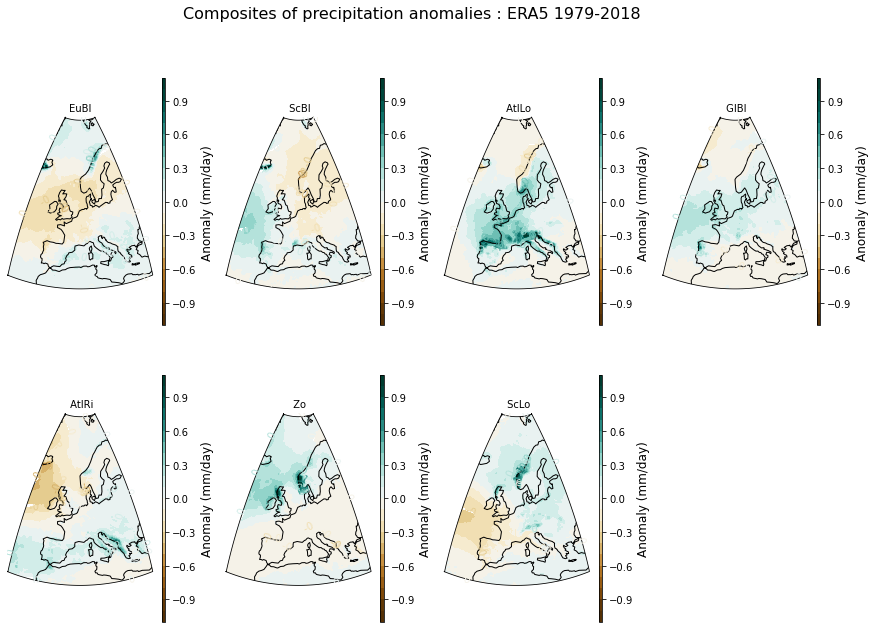

In [27]:
projection2=ccrs.NearsidePerspective(central_longitude=5.0, central_latitude=55.0)
bounds = [(-20, 30, 30, 80)]
cmap3='BrBG'

levs_tp_anom = np.linspace(-1, 1, 21)

fig = plt.figure(figsize=(15, 10))
fig.suptitle('Composites of precipitation anomalies : ERA5 1979-2018', fontsize=16)

ax = fig.add_subplot(2, 4, 1, projection=projection2)
plt.title(Regimes[0], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lon_t, lat_t, mean_c1_anom_tp, levels=levs_tp_anom, 
                 cmap=cmap3, extend='both', transform=ccrs.PlateCarree())
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly (mm/day)', fontsize=12)

ax = fig.add_subplot(2, 4, 2, projection=projection2)
plt.title(Regimes[1], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lon_t, lat_t, mean_c2_anom_tp, levels=levs_tp_anom, 
                 cmap=cmap3, extend='both', transform=ccrs.PlateCarree())
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly (mm/day)', fontsize=12)

ax = fig.add_subplot(2, 4, 3, projection=projection2)
plt.title(Regimes[2], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lon_t, lat_t, mean_c3_anom_tp, levels=levs_tp_anom, 
                 cmap=cmap3, extend='both', transform=ccrs.PlateCarree())
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly (mm/day)', fontsize=12)

ax = fig.add_subplot(2, 4, 4, projection=projection2)
plt.title(Regimes[3], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lon_t, lat_t, mean_c4_anom_tp, levels=levs_tp_anom, 
                 cmap=cmap3, extend='both', transform=ccrs.PlateCarree())
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly (mm/day)', fontsize=12)

ax = fig.add_subplot(2, 4, 5, projection=projection2)
plt.title(Regimes[4], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lon_t, lat_t, mean_c5_anom_tp, levels=levs_tp_anom, 
                 cmap=cmap3, extend='both', transform=ccrs.PlateCarree())
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly (mm/day)', fontsize=12)

ax = fig.add_subplot(2, 4, 6, projection=projection2)
plt.title(Regimes[5], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lon_t, lat_t, mean_c6_anom_tp, levels=levs_tp_anom, 
                 cmap=cmap3, extend='both', transform=ccrs.PlateCarree())
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly (mm/day)', fontsize=12)

ax = fig.add_subplot(2, 4, 7, projection=projection2)
plt.title(Regimes[6], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lon_t, lat_t, mean_c7_anom_tp, levels=levs_tp_anom, 
                 cmap=cmap3, extend='both', transform=ccrs.PlateCarree())
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly (mm/day)', fontsize=12)

plt.show()

fig.savefig(dir_figs+'z500_eu_tp_composite'+'.jpeg', bbox_inches='tight')